Part #1: Data Processing

In [1]:
import pandas as pd

file_path = '/Users/Malianboy/Desktop/GWU/Spring 2024/ECE6610_Brian/final project/EM-CURE Assignment/Dataset/largeoffice.csv'

df = pd.read_csv(file_path)
df.head()

/var/folders/gx/7392jy7j3vq80mb851zxz3fc0000gn/T/ipykernel_28296/1130921399.py:5: DtypeWarning: Columns (9,12,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,state,in.building_type,timestamp,models_used,floor_area_represented,out.district_cooling.cooling.energy_consumption,out.district_heating.heating.energy_consumption,out.district_heating.water_systems.energy_consumption,out.electricity.cooling.energy_consumption,out.electricity.exterior_lighting.energy_consumption,...,out.natural_gas.interior_equipment.energy_consumption,out.natural_gas.water_systems.energy_consumption,out.district_cooling.total.energy_consumption,out.district_heating.total.energy_consumption,out.electricity.total.energy_consumption,out.natural_gas.total.energy_consumption,out.other_fuel.heating.energy_consumption,out.other_fuel.water_systems.energy_consumption,out.other_fuel.total.energy_consumption,out.site_energy.total.energy_consumption
0,DC,LargeOffice,2018-01-01 00:15:00,41,1.286979e+08,0.0,0.0,0.0,3882.87,1276.74,...,0.0,16.36,0.0,0.0,46766.14,25891.14,0.0,5.93,5.93,72663.21
1,DC,LargeOffice,2018-01-01 00:30:00,41,1.286979e+08,0.0,0.0,0.0,3907.22,1276.74,...,0.0,36.42,0.0,0.0,47354.76,26688.12,0.0,0.00,0.00,74042.88
2,DC,LargeOffice,2018-01-01 00:45:00,41,1.286979e+08,0.0,0.0,0.0,3901.59,1276.74,...,0.0,32.54,0.0,0.0,46940.14,16180.76,0.0,4.64,4.64,63125.55
3,DC,LargeOffice,2018-01-01 01:00:00,41,1.286979e+08,0.0,0.0,0.0,3904.37,1276.74,...,0.0,24.18,0.0,0.0,47801.87,26931.97,0.0,0.00,0.00,74733.84
4,DC,LargeOffice,2018-01-01 01:15:00,41,1.286979e+08,0.0,0.0,0.0,3803.55,1276.74,...,0.0,64.55,0.0,0.0,46278.37,26971.45,0.0,0.00,0.00,73249.82


Part #1.1

In [2]:
load_columns = df.columns[5:]

corruption_report = []

corrupted_points = []

for column in load_columns:
    invalid_rows = df[~pd.to_numeric(df[column], errors='coerce').notna()]
    
    if not invalid_rows.empty:
        for index, row in invalid_rows.iterrows():
            corruption_report.append({
                "File Name": "largeoffice.csv",
                "Row Number": index,
                "Column": column,
                "Corrupted Data": row[column]
            })
            corrupted_points.append((index, column))

corruption_report_df = pd.DataFrame(corruption_report)
display(corruption_report_df)

#corruption_report_df, len(corruption_report_df)


,File Name,Row Number,Column,Corrupted Data
0,largeoffice.csv,108,out.electricity.exterior_lighting.energy_consu...,bad
1,largeoffice.csv,424,out.electricity.heat_rejection.energy_consumption,data
2,largeoffice.csv,2752,out.electricity.pumps.energy_consumption,really
3,largeoffice.csv,30125,out.natural_gas.heating.energy_consumption,sucks


Part #1.2:
1.2.1.What would happen if you replaced it with a 0?
Replacing the corrupted data point with a 0 would create a significant and unrealistic drop in the energy consumption data. Since the data represents time-series energy consumption in kWh, a zero value can drastically skew downstream analysis. For example, it may lead to incorrect conclusions when calculating consumption trends, peaks, or efficiency metrics.
1.2.2.What would happen if you deleted that row completely?
Deleting the entire row would result in the loss of a 15-minute interval from the dataset. This would create a gap in the time series, which could lead to issues if the data is used for time-based analysis like forecasting or trend identification. 
1.2.3.What is the correct way to deal with this corrupted data?
The correct approach would be to use linear interpolation to estimate the corrupted data point. This technique involves computing an estimated value based on the preceding and succeeding data points. This way, the time series remains continuous, and the imputed value aligns more realistically with surrounding consumption patterns.

Part #1.3

In [3]:
def interpolate_value(df, index, column):
    preceding_index = index - 1
    superseding_index = index + 1
    
    # Extract the preceding and superseding numeric values
    preceding_value = pd.to_numeric(df.loc[preceding_index, column], errors='coerce')
    superseding_value = pd.to_numeric(df.loc[superseding_index, column], errors='coerce')
    
    # If one of the neighbors is NaN, use the other neighbor's value
    if pd.isna(preceding_value) and not pd.isna(superseding_value):
        replacement_value = superseding_value
    elif not pd.isna(preceding_value) and pd.isna(superseding_value):
        replacement_value = preceding_value
    else:
        replacement_value = preceding_value + ((superseding_value - preceding_value) / 2)
    
    return replacement_value, preceding_value, superseding_value

correction_report = []

for index, column in corrupted_points:
    replacement_value, preceding_value, superseding_value = interpolate_value(df, index, column)
    df.loc[index, column] = replacement_value
    correction_report.append({
        "File Name": "largeoffice.csv",
        "Row Number": index,
        "Column": column,
        "Preceding Data Point": preceding_value,
        "Superseding Data Point": superseding_value,
        "Replaced Value": replacement_value
    })

correction_report_df = pd.DataFrame(correction_report)

corrected_file_path = '/Users/Malianboy/Desktop/GWU/Spring 2024/ECE6610_Brian/final project/EM-CURE Assignment/Dataset/largeoffice_fixed.csv'
df.to_csv(corrected_file_path, index=False)

# Display the correction report
# correction_report_df, corrected_file_path
display(correction_report_df)


,File Name,Row Number,Column,Preceding Data Point,Superseding Data Point,Replaced Value
0,largeoffice.csv,108,out.electricity.exterior_lighting.energy_consu...,1276.74,1276.74,1276.740
1,largeoffice.csv,424,out.electricity.heat_rejection.energy_consumption,15.50,15.65,15.575
2,largeoffice.csv,2752,out.electricity.pumps.energy_consumption,1799.33,1810.48,1804.905
3,largeoffice.csv,30125,out.natural_gas.heating.energy_consumption,10532.02,12202.22,11367.120


Part #2 Data Visualization:
2.1. 
Pie Chart
What it represents: Distribution of electricity consumption by different systems (e.g., fans, pumps, lighting).

Why it's worth representing: This plot would visually depict the proportion of total electricity used by various systems. Understanding how energy is distributed can help in identifying which areas consume the most power and potentially offer the greatest opportunities for energy savings or efficiency improvements.

Time Series Line Chart (Interactie)
What it represents: Hourly variations in energy consumption based on percentiles and averages for different energy sources.

Why it's worth representing: The chart provides insights into the hourly patterns of energy usage, allowing for clear identification of peak periods. By using percentile bands and average lines, the plot highlights variability and trends over time, facilitating more informed decision-making for energy management and efficiency planning. The interactive nature of the chart allows for easy comparison between different datasets, revealing consumption trends across different energy sources.

Heatmap (Interactive)
What it represents: Daily distribution of energy consumption over the course of a year, segmented by hour.

Why it's worth representing: The interactive heatmap allows for a quick visual assessment of energy usage patterns throughout the day across different times of the year. Users can select different energy consumption metrics via a dropdown menu, adapting the display to various aspects of the dataset. This functionality is essential for identifying trends, peak consumption times, and periods of low energy use across multiple variables, aiding in strategic energy management and operational optimization. The color coding enhances the readability of complex data, making it easier to spot anomalies and consistent patterns while the interactivity enriches user engagement and data exploration.

Part #2.2

,out.district_cooling.cooling.energy_consumption,out.district_heating.heating.energy_consumption,out.district_heating.water_systems.energy_consumption,out.electricity.cooling.energy_consumption,out.electricity.exterior_lighting.energy_consumption,out.electricity.fans.energy_consumption,out.electricity.heat_recovery.energy_consumption,out.electricity.heat_rejection.energy_consumption,out.electricity.heating.energy_consumption,out.electricity.interior_equipment.energy_consumption,...,out.natural_gas.interior_equipment.energy_consumption,out.natural_gas.water_systems.energy_consumption,out.district_cooling.total.energy_consumption,out.district_heating.total.energy_consumption,out.electricity.total.energy_consumption,out.natural_gas.total.energy_consumption,out.other_fuel.heating.energy_consumption,out.other_fuel.water_systems.energy_consumption,out.other_fuel.total.energy_consumption,out.site_energy.total.energy_consumption
0,0.0,0.0,0.0,3882.87,1276.74,6882.18,4.75,24.36,4032.89,26967.82,...,0.0,16.36,0.0,0.0,46766.14,25891.14,0.0,5.93,5.93,72663.21
1,0.0,0.0,0.0,3907.22,1276.74,6957.77,4.75,23.84,4209.14,27149.84,...,0.0,36.42,0.0,0.0,47354.76,26688.12,0.0,0.00,0.00,74042.88
2,0.0,0.0,0.0,3901.59,1276.74,6611.03,4.75,23.23,4215.40,27089.82,...,0.0,32.54,0.0,0.0,46940.14,16180.76,0.0,4.64,4.64,63125.55
3,0.0,0.0,0.0,3904.37,1276.74,7034.50,4.75,22.61,4337.87,27260.29,...,0.0,24.18,0.0,0.0,47801.87,26931.97,0.0,0.00,0.00,74733.84
4,0.0,0.0,0.0,3803.55,1276.74,6873.58,4.75,22.44,3082.16,27243.82,...,0.0,64.55,0.0,0.0,46278.37,26971.45,0.0,0.00,0.00,73249.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,0.0,0.0,0.0,4670.79,1289.32,3955.68,4.75,101.19,480.58,27024.88,...,0.0,94.91,0.0,0.0,41577.08,2154.02,0.0,10.03,10.03,43741.13
35036,0.0,0.0,0.0,4621.81,1289.32,3795.83,4.75,102.97,470.17,26936.82,...,0.0,80.29,0.0,0.0,41252.13,2036.42,0.0,8.41,8.41,43296.95
35037,0.0,0.0,0.0,4547.21,1289.32,3891.87,4.75,104.81,472.64,26889.43,...,0.0,58.60,0.0,0.0,41220.10,1630.45,0.0,12.14,12.14,42862.69
35038,0.0,0.0,0.0,4636.89,1289.32,3402.68,4.75,107.33,427.09,26889.95,...,0.0,75.42,0.0,0.0,40779.48,2113.91,0.0,6.02,6.02,42899.42


Index(['out.district_cooling.cooling.energy_consumption',
       'out.district_heating.heating.energy_consumption',
       'out.district_heating.water_systems.energy_consumption',
       'out.electricity.refrigeration.energy_consumption',
       'out.natural_gas.interior_equipment.energy_consumption',
       'out.district_cooling.total.energy_consumption',
       'out.district_heating.total.energy_consumption',
       'out.other_fuel.heating.energy_consumption'],
      dtype='object')

,out.electricity.cooling.energy_consumption,out.electricity.exterior_lighting.energy_consumption,out.electricity.fans.energy_consumption,out.electricity.heat_recovery.energy_consumption,out.electricity.heat_rejection.energy_consumption,out.electricity.heating.energy_consumption,out.electricity.interior_equipment.energy_consumption,out.electricity.interior_lighting.energy_consumption,out.electricity.pumps.energy_consumption,out.electricity.water_systems.energy_consumption,out.natural_gas.heating.energy_consumption,out.natural_gas.water_systems.energy_consumption,out.natural_gas.total.energy_consumption,out.other_fuel.water_systems.energy_consumption,out.other_fuel.total.energy_consumption
0,3882.87,1276.74,6882.18,4.75,24.36,4032.89,26967.82,2740.21,941.80,12.51,25874.77,16.36,25891.14,5.93,5.93
1,3907.22,1276.74,6957.77,4.75,23.84,4209.14,27149.84,2869.45,943.31,12.70,26651.70,36.42,26688.12,0.00,0.00
2,3901.59,1276.74,6611.03,4.75,23.23,4215.40,27089.82,2874.65,927.88,15.05,16148.22,32.54,16180.76,4.64,4.64
3,3904.37,1276.74,7034.50,4.75,22.61,4337.87,27260.29,3003.14,947.81,9.79,26907.79,24.18,26931.97,0.00,0.00
4,3803.55,1276.74,6873.58,4.75,22.44,3082.16,27243.82,3016.01,947.03,8.31,26906.90,64.55,26971.45,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,4670.79,1289.32,3955.68,4.75,101.19,480.58,27024.88,2599.19,1414.26,36.43,2059.11,94.91,2154.02,10.03,10.03
35036,4621.81,1289.32,3795.83,4.75,102.97,470.17,26936.82,2588.89,1412.90,28.68,1956.12,80.29,2036.42,8.41,8.41
35037,4547.21,1289.32,3891.87,4.75,104.81,472.64,26889.43,2581.52,1412.85,25.71,1571.85,58.60,1630.45,12.14,12.14
35038,4636.89,1289.32,3402.68,4.75,107.33,427.09,26889.95,2577.44,1415.06,28.98,2038.49,75.42,2113.91,6.02,6.02


,out.electricity.cooling.energy_consumption,out.electricity.exterior_lighting.energy_consumption,out.electricity.fans.energy_consumption,out.electricity.heat_recovery.energy_consumption,out.electricity.heat_rejection.energy_consumption,out.electricity.heating.energy_consumption,out.electricity.interior_equipment.energy_consumption,out.electricity.interior_lighting.energy_consumption,out.electricity.pumps.energy_consumption,out.electricity.water_systems.energy_consumption
0,3882.87,1276.74,6882.18,4.75,24.36,4032.89,26967.82,2740.21,941.80,12.51
1,3907.22,1276.74,6957.77,4.75,23.84,4209.14,27149.84,2869.45,943.31,12.70
2,3901.59,1276.74,6611.03,4.75,23.23,4215.40,27089.82,2874.65,927.88,15.05
3,3904.37,1276.74,7034.50,4.75,22.61,4337.87,27260.29,3003.14,947.81,9.79
4,3803.55,1276.74,6873.58,4.75,22.44,3082.16,27243.82,3016.01,947.03,8.31
...,...,...,...,...,...,...,...,...,...,...
35035,4670.79,1289.32,3955.68,4.75,101.19,480.58,27024.88,2599.19,1414.26,36.43
35036,4621.81,1289.32,3795.83,4.75,102.97,470.17,26936.82,2588.89,1412.90,28.68
35037,4547.21,1289.32,3891.87,4.75,104.81,472.64,26889.43,2581.52,1412.85,25.71
35038,4636.89,1289.32,3402.68,4.75,107.33,427.09,26889.95,2577.44,1415.06,28.98


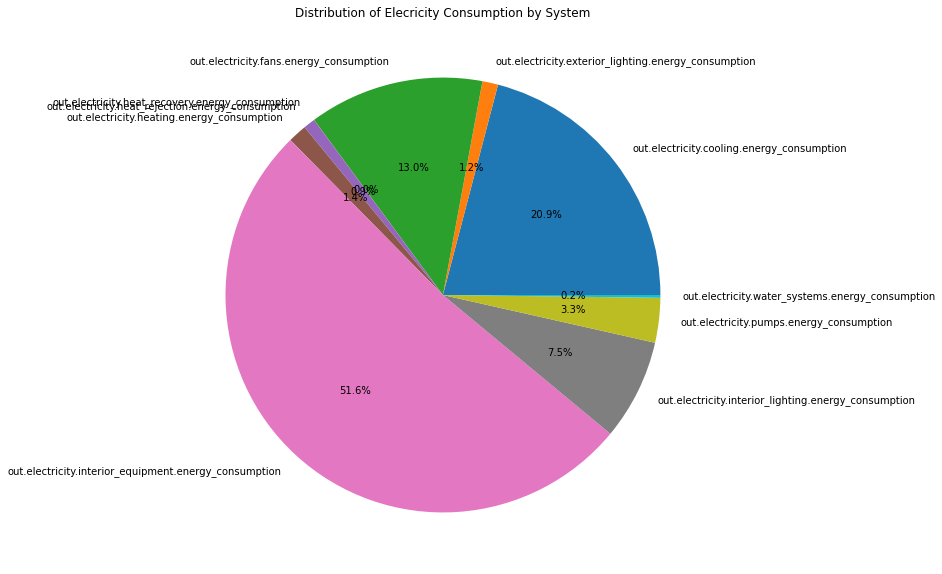

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
file_path2 = '/Users/Malianboy/Desktop/GWU/Spring 2024/ECE6610_Brian/final project/EM-CURE Assignment/Dataset/largeoffice_fixed.csv'
df2 = pd.read_csv(file_path2)
load_columns2 = df2.columns[5:]
load_columns2_df = df2[load_columns2]
display(load_columns2_df)

zero_columns = load_columns2_df.columns[(load_columns2_df == 0).all()]
df_clean = load_columns2_df.drop(zero_columns, axis=1)
if ('out.site_energy.total.energy_consumption' in df_clean.columns) and ('out.electricity.total.energy_consumption' in df_clean.columns):
    df_clean = df_clean.drop(['out.site_energy.total.energy_consumption', 'out.electricity.total.energy_consumption'], axis=1)
display(zero_columns)
display(df_clean)

electricity_columns = [col for col in df_clean.columns if 'out.electricity' in col and 'energy_consumption' in col]
electricity_df = df_clean[electricity_columns]
display(electricity_df)

mean_consumption = electricity_df.mean()
plt.figure(figsize=(10, 10))
mean_consumption.plot(kind='pie', autopct='%1.1f%%')
plt.title("Distribution of Elecricity Consumption by System")
plt.ylabel("")
plt.show()

Time Series Line Chart

In [6]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

#file_path = '/Users/Malianboy/Desktop/GWU/Spring 2024/ECE6610_Brian/final project/EM-CURE Assignment/Dataset/fullservicerestaurant_fixed.csv'
file_path = '/Users/Malianboy/Desktop/GWU/Spring 2024/ECE6610_Brian/final project/EM-CURE Assignment/Dataset/largeoffice_fixed.csv'
#file_path = '/Users/Malianboy/Desktop/GWU/Spring 2024/ECE6610_Brian/final project/EM-CURE Assignment/Dataset/largehotel_fixed.csv'

df = pd.read_csv(file_path)

# Convert 'timestamp' to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour

# columns_to_analyze = [
#     'out.site_energy.total.energy_consumption',
#     'out.natural_gas.interior_equipment.energy_consumption'
# ]
columns_to_analyze = df.columns[5:]

fig = go.Figure()

# Function to create traces for a given column
def create_traces(column_name):
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')

    percentiles = [0, 25, 50, 75, 100]
    percentile_data = df.groupby('hour')[column_name].quantile([0, 0.25, 0.50, 0.75, 1.0]).unstack()
    average_data = df.groupby('hour')[column_name].mean()

    percentile_names = ['0th %', '25th %', '50th %', '75th %', '100th %']
    traces = []
    for i, name in enumerate(percentile_names):
        traces.append(go.Scatter(x=percentile_data.index, y=percentile_data.iloc[:, i], mode='lines', name=f'{name} - {column_name}', visible=False))
    traces.append(go.Scatter(x=average_data.index, y=average_data, mode='lines', name=f'Ann. Avg. - {column_name}', visible=False, line=dict(dash='dash')))
    return traces

all_traces = []
for column in columns_to_analyze:
    all_traces.extend(create_traces(column))

for trace in all_traces:
    fig.add_trace(trace)

buttons = []
for i, column in enumerate(columns_to_analyze):
    visibility = [False] * len(all_traces)  
    start = i * 6  
    for j in range(start, start + 6):
        visibility[j] = True

    button = dict(
        label=column,
        method="update",
        args=[{"visible": visibility},
              {"title": f"Electricity Load - {column}"}]
    )
    buttons.append(button)

# Set the first dataset to be visible initially
for i in range(6):
    all_traces[i]['visible'] = True

# Compute the max for the y-axis dynamically across all analyzed columns
max_y_value = df[columns_to_analyze].max().max() * 1.1  

fig.update_layout(
    updatemenus=[{
        "buttons": buttons,
        "direction": "down",
        "showactive": True,
        "x": 0.95,
        "xanchor": "left",
        "y": 1.15,
        "yanchor": "top"
    }],
    title="Electricity Load - Select Data Set",
    xaxis_title="Hour of the Day",
    yaxis_title="Electricity Consumption (kW)",
    yaxis=dict(range=[0, max_y_value])
)

annotations = [
    dict(x=9, y=0, xref='x', yref='y', text='Business Hour - Start', showarrow=True, arrowhead=1, ax=-40, ay=-30),
    #dict(x=13, y=0, xref='x', yref='y', text='Lunch Rush', showarrow=True, arrowhead=1, ax=0, ay=-30),
    dict(x=17, y=0, xref='x', yref='y', text='Business Hour - End of Day', showarrow=True, arrowhead=1, ax=40, ay=-30)
]
fig.update_layout(annotations=annotations)

fig.show()


Heatmap

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown

# Load the data
data = pd.read_csv('/Users/Malianboy/Desktop/GWU/Spring 2024/ECE6610_Brian/final project/EM-CURE Assignment/Dataset/largeoffice_fixed.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Adding month and hour of day columns
data['month'] = data['timestamp'].dt.month
data['hour_of_day'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60

# List of columns to include in the dropdown
metered_columns = data.columns[5:]  

def plot_heatmap(column):
    pivot_table = data.pivot_table(values=column, index='month', columns='hour_of_day', aggfunc=np.mean)
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, cmap='viridis', cbar_kws={'label': 'Energy Consumption (kWh)'})
    plt.title(f'Heatmap of Monthly {column}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Month')
    plt.show()

# Create dropdown and interact function to update plot
dropdown = Dropdown(options=metered_columns)
interact(plot_heatmap, column=dropdown)


interactive(children=(Dropdown(description='column', options=('out.district_cooling.cooling.energy_consumption…

<function __main__.plot_heatmap(column)>